### Feature Engineering

Add these features:  "Mean"; "Std"; "Skewness"; "Kurtosis"; "Peak2Peak";
"RMS"; "CrestFactor"; "ShapeFactor"; "ImpulseFactor"; "MarginFactor"; "Energy";
"SKMean"; "SKStd"; "SKSkewness"; "SKKurtosis"

In [1]:
import os
import numpy as np
import pandas as pd
import pickle
from scipy import signal
from scipy.stats import skew, kurtosis

def spectral_kurtosis(x, fs, window_size=128):
    n = len(x)
    nperseg = 8192
    # MATLAB's pkurtosis uses 80% overlap
    noverlap = int(0.8 * nperseg)

    f, t, Zxx = signal.stft(x, fs=fs, window='hann', nperseg=nperseg, noverlap=noverlap, scaling='spectrum')
    
    # Compute power spectral density
    power = np.abs(Zxx)**2

    # For spectral kurtosis, we need to compute the 4th order moment
    # MATLAB's approach normalizes the power at each frequency
    sk = np.zeros(len(f))

    for i in range(len(f)):
        # Power values at frequency f[i] across all time segments
        Pi = power[i, :]
        
        if len(Pi) > 1:
            # Compute statistical moments
            E_P = np.mean(Pi)         # E[|X(f,t)|^2]
            E_P2 = np.mean(Pi**2)     # E[|X(f,t)|^4]
            
            # Antoni's spectral kurtosis formula
            if E_P > 1e-20:  # Avoid division by very small numbers
                sk[i] = E_P2 / (E_P**2) - 2
            else:
                sk[i] = 0
        else:
            sk[i] = 0
    
    # Clip extreme values that might occur due to numerical issues
    sk = np.clip(sk, -10, 10)
    
    return f, sk

folder = "wind_turbine_pkl"

# List to hold feature rows
all_features = []

# Sort files so they are in order
files = sorted([f for f in os.listdir(folder) if f.startswith("wt_") and f.endswith(".pkl")])

for file in files:
    with open(os.path.join(folder, file), "rb") as f:
        data = pickle.load(f)

    # Vibration signal
    v = np.array(data["vibration"])

    # Compute spectral kurtosis
    f, sk = spectral_kurtosis(v, fs=97656, window_size=128)
    # Compute mean of spectral kurtosis across frequencies
    sk_mean = np.mean(sk)

    features = {
        "Date": data["date"],
        "Mean": np.mean(v),
        "Std": np.std(v),
        "Skewness": skew(v),
        "Kurtosis": kurtosis(v, fisher=True, bias=False),
        "Peak2Peak": np.ptp(v),
        "RMS": np.sqrt(np.mean(v**2)),
        "CrestFactor": np.max(np.abs(v)) / np.sqrt(np.mean(v**2)),
        "ShapeFactor": np.sqrt(np.mean(v**2)) / np.mean(np.abs(v)),
        "ImpulseFactor": np.max(np.abs(v)) / np.mean(np.abs(v)),
        "MarginFactor": np.max(np.abs(v)) / (np.mean(np.abs(v))**2),
        "Energy": np.sum(v**2),
        "SKMean": sk_mean,
        "SKStd": np.std(sk),
        "SKSkewness": skew(sk),
        "SKKurtosis": kurtosis(sk, fisher=True, bias=False),
    }

    all_features.append(features)

# Combine into a df and save
features_df = pd.DataFrame(all_features)
features_df.to_csv("wt_bearing_features.csv", index=False)


In [2]:
features_df.head()

,Date,Mean,Std,Skewness,Kurtosis,Peak2Peak,RMS,CrestFactor,ShapeFactor,ImpulseFactor,MarginFactor,Energy,SKMean,SKStd,SKSkewness,SKKurtosis
0,2013-03-07 01:57:46,0.346052,2.270481,0.003870,-0.004378,21.621068,2.296702,4.914735,1.253517,6.160703,3.362451,3.090718e+06,-0.031796,0.173083,3.594882,87.544129
1,2013-03-16 06:56:43,0.233177,1.984203,-0.001959,0.007185,18.831975,1.997857,5.048283,1.253975,6.330421,3.973352,2.338725e+06,-0.017619,0.141520,0.592585,5.379565
2,2013-03-17 06:56:04,0.216575,2.113041,-0.001371,0.124720,21.857696,2.124111,5.485731,1.258684,6.904800,4.091575,2.643653e+06,-0.003562,0.151454,0.898361,5.400596
3,2013-03-17 18:47:56,0.193808,2.133505,-0.012744,0.093440,21.588679,2.142290,5.319964,1.257507,6.689893,3.926914,2.689098e+06,0.080846,0.396414,11.434816,224.319572
4,2013-03-18 18:47:15,0.219193,2.128356,-0.000204,0.164703,24.050760,2.139613,5.788313,1.259477,7.290247,4.291382,2.682383e+06,0.040240,0.220886,5.561441,87.782453


Smooth the features with 5 day rolling average

In [3]:
# sort by date
features_df["Date"] = pd.to_datetime(features_df["Date"])
features_df = features_df.sort_values("Date").reset_index(drop=True)

def matlab_causal_movmean(data, window_size):
    result = np.zeros_like(data, dtype=float)
    
    for i in range(len(data)):
        # Causal window: look back up to window_size-1 samples, plus current sample
        start_idx = max(0, i - window_size + 1)
        end_idx = i + 1  # +1 because slicing is exclusive of end
        
        # Take mean of the window
        result[i] = np.mean(data[start_idx:end_idx])
    
    return result
# Create a copy for smoothing (don't modify original)
features_df_smooth = features_df.copy()

# Get date column
date_col = features_df["Date"]

# Apply MATLAB-style causal moving mean to numeric columns
numeric_columns = features_df.select_dtypes(include=[np.number]).columns

for col in numeric_columns:
    # Apply causal moving mean with window=5, lag=[5,0] 
    features_df_smooth[col] = matlab_causal_movmean(features_df[col].values, window_size=5)

# Save smoothed features
features_df_smooth.to_csv("wt_bearing_features_smooth.csv", index=False)


plot what smoothing did

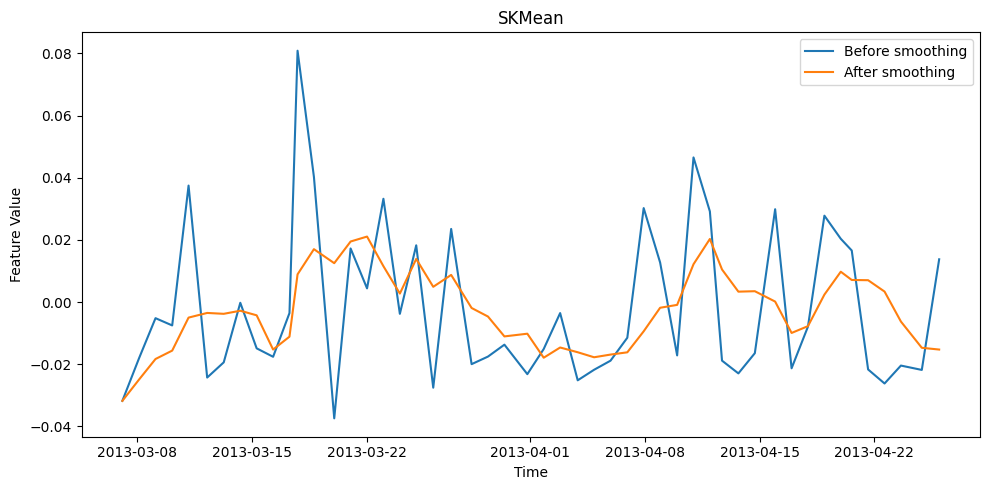

In [4]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.plot(features_df["Date"], features_df["SKMean"], label="Before smoothing")
plt.plot(features_df_smooth["Date"], features_df_smooth["SKMean"], label="After smoothing")
plt.xlabel("Time")
plt.ylabel("Feature Value")
plt.title("SKMean")
plt.legend()
plt.tight_layout()
plt.show()


Get training data

In [5]:
from datetime import datetime

# 40% of data will be used for training, the cutoff date is March 27 2013
breaktime = datetime(2013, 3, 27)

features_df_smooth["Date"] = pd.to_datetime(features_df_smooth["Date"])
breakpoint = features_df_smooth[features_df_smooth["Date"] < breaktime].index.max()

train_data = features_df_smooth.loc[:breakpoint].copy()

Rank features based on monotonicity

In [6]:
def monotonicity(train_data):
    monotonicity_scores = {}

    n = len(train_data)
    for col in train_data.columns:
        x = train_data[col].values
        diffs = np.diff(x)
        pos_count = np.sum(diffs > 0)
        neg_count = np.sum(diffs < 0)
        score = abs(pos_count - neg_count) / (n - 1)
        monotonicity_scores[col] = score
    
    return pd.Series(monotonicity_scores)

# get rid of date columns
numeric_train_data = train_data.select_dtypes(include=[np.number])

feature_importance = monotonicity(numeric_train_data)
print(feature_importance.sort_values(ascending=False))

MarginFactor     0.578947
Mean             0.368421
Kurtosis         0.368421
ShapeFactor      0.263158
SKMean           0.263158
SKSkewness       0.263158
Skewness         0.157895
ImpulseFactor    0.157895
SKStd            0.157895
Std              0.052632
Peak2Peak        0.052632
RMS              0.052632
CrestFactor      0.052632
Energy           0.052632
SKKurtosis       0.052632
dtype: float64


Matlab writes that - Features with feature importance score larger than 0.3 are selected for feature fusion in the next section. Our highest is .2 , but we also do not have sk features yet. I will use the top 3.

In [7]:
selected_features = feature_importance[feature_importance > 0.14].index.tolist()

# Select those features from the trainData and featureTableSmooth DataFrames
train_data_selected = train_data[['Date'] + selected_features]
feature_selected = features_df_smooth[['Date'] + selected_features]

In [8]:
import numpy as np
from sklearn.decomposition import PCA

# 1. Extract the raw values (drop 'Date' column if present)
X_train = train_data_selected.drop(columns='Date').values
X_full = feature_selected.drop(columns='Date').values

# 2. Compute mean and std from training data
mean_train = X_train.mean(axis=0)
std_train = X_train.std(axis=0)

# 3. Normalize training data
X_train_norm = (X_train - mean_train) / std_train

# 4. Fit PCA on normalized training data
pca = PCA()
pca.fit(X_train_norm)

# 5. Normalize entire smoothed dataset using training mean/std
X_full_norm = (X_full - mean_train) / std_train

# 6. Apply PCA transformation to get principal components
PCA1 = X_full_norm @ pca.components_[0]
PCA2 = X_full_norm @ pca.components_[1]

# Optional: Create a DataFrame with Dates and PCA scores
pca_df = feature_selected[['Date']].copy()
pca_df['PCA1'] = PCA1
pca_df['PCA2'] = PCA2


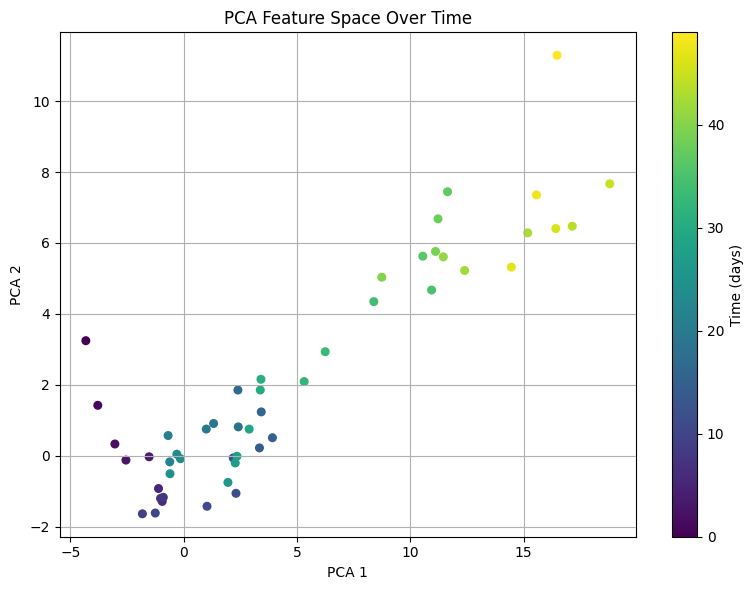

In [9]:
import matplotlib.pyplot as plt

# Assuming PCA1, PCA2, and feature_selected['Date'] exist

num_data = len(PCA1)
color_vals = np.arange(num_data)

plt.figure(figsize=(8, 6))
scatter = plt.scatter(PCA1, PCA2, c=color_vals, cmap='viridis', s=30)
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')

# Add colorbar with label
cbar = plt.colorbar(scatter)
cbar.set_label('Time (days)')  # Adjust if using different units

plt.title('PCA Feature Space Over Time')
plt.grid(True)
plt.tight_layout()
plt.show()


this looks like both PCA 1 and 2 are good health indicators

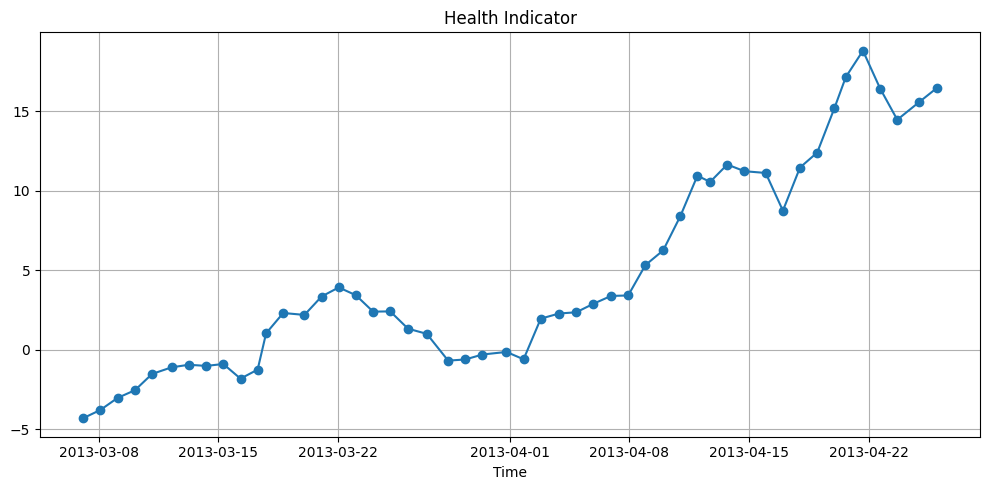

In [10]:
import matplotlib.pyplot as plt

# Assuming feature_selected["Date"] and PCA1 are already defined
health_indicator = PCA1

plt.figure(figsize=(10, 5))
plt.plot(feature_selected["Date"], health_indicator, marker='o', linestyle='-')
plt.xlabel("Time")
plt.title("Health Indicator")
plt.grid(True)
plt.tight_layout()
plt.show()


In [11]:
# Shift the health indicator to start at 0
health_indicator_shifted = health_indicator - health_indicator[0]
threshold = health_indicator_shifted[-1]


In [12]:
# Constants from the MATLAB model setup
phi = -1
theta_mean = 1
theta_var = 1e6
beta_mean = 1
beta_var = 1e6

# Compute noise variance from threshold
noise_std = (0.1 * threshold) / (threshold - phi)
noise_var = noise_std ** 2

# Slope detection threshold (for p-value)
slope_detection_level = 0.05



In [13]:
import numpy as np
from scipy.stats import norm

class ExponentialDegradationModel:
    def __init__(self, phi, theta_mean, theta_var, beta_mean, beta_var, noise_var, slope_detection_level=0.05):
        self.phi = phi
        self.noise_var = noise_var
        self.slope_detection_level = slope_detection_level
        
        self.reset(theta_mean, theta_var, beta_mean, beta_var)

    def reset(self, theta_mean, theta_var, beta_mean, beta_var):
        self.mean = np.array([np.log(theta_mean), beta_mean])  # we work in log(theta)
        self.cov = np.diag([theta_var / (theta_mean ** 2), beta_var])  # cov for [ln(theta), beta]
        self.history = []  # store [t, h(t)]
        self.p_values = []

    def update(self, t, h_t):
        if h_t <= self.phi:
            return  # skip invalid values

        y_t = np.log(h_t - self.phi)
        x_vec = np.array([1, t])  # design vector

        S = x_vec @ self.cov @ x_vec.T + self.noise_var
        K = self.cov @ x_vec.T / S
        residual = y_t - x_vec @ self.mean

        self.mean = self.mean + K * residual
        self.cov = self.cov - np.outer(K, x_vec) @ self.cov

        # slope detection
        beta_std = np.sqrt(self.cov[1, 1])
        z_score = self.mean[1] / beta_std
        p_val = 2 * (1 - norm.cdf(abs(z_score)))
        self.p_values.append(p_val)

        # forget if slope just became significant
        if len(self.p_values) > 1 and self.p_values[-2] >= self.slope_detection_level and p_val < self.slope_detection_level:
            self.reset(np.exp(self.mean[0]), self.cov[0, 0] * np.exp(self.mean[0])**2, self.mean[1], self.cov[1, 1])

        self.history.append([t, h_t])

    def predict_rul(self, t_now, h_now, threshold, num_samples=1000):
        alpha, beta = self.mean
        cov = self.cov

        # Monte Carlo sampling of [alpha, beta]
        samples = np.random.multivariate_normal(self.mean, self.cov, size=num_samples)

        rul_samples = []
        for a, b in samples:
            theta = np.exp(a)
            if b <= 0:
                continue
            try:
                t_failure = (np.log((threshold - self.phi) / theta)) / b
                rul = max(t_failure - t_now, 0)
                rul_samples.append(rul)
            except:
                continue

        if len(rul_samples) == 0:
            return np.nan, (np.nan, np.nan), np.array([])

        est_rul = np.mean(rul_samples)
        ci_lower, ci_upper = np.percentile(rul_samples, [5, 95])
        return est_rul, (ci_lower, ci_upper), np.array(rul_samples)



In [14]:
# Convert dates to seconds from start
time_numeric = (feature_selected['Date'] - feature_selected['Date'].iloc[0]).dt.total_seconds().values
health_data = health_indicator  # unshifted; will subtract phi inside model

# Initialize model
mdl = ExponentialDegradationModel(
    phi=phi,
    theta_mean=theta_mean,
    theta_var=theta_var,
    beta_mean=beta_mean,
    beta_var=beta_var,
    noise_var=noise_var,
    slope_detection_level=slope_detection_level
)

# Run over time series
est_ruls = []
true_ruls = []

for i in range(len(health_data) - 1):
    t = time_numeric[i]
    h = health_data[i]

    mdl.update(t, h)

    # Predict RUL from current time/health
    est_rul = mdl.predict_rul(t, h, threshold)
    est_ruls.append(est_rul)

    true_rul = time_numeric[-1] - t
    true_ruls.append(true_rul)


/var/folders/2m/sdkhr0n547l_ypwwkd8msbmw0000gn/T/ipykernel_66672/2839859096.py:53: RuntimeWarning: overflow encountered in exp
  theta = np.exp(a)
/var/folders/2m/sdkhr0n547l_ypwwkd8msbmw0000gn/T/ipykernel_66672/2839859096.py:57: RuntimeWarning: divide by zero encountered in log
  t_failure = (np.log((threshold - self.phi) / theta)) / b
/var/folders/2m/sdkhr0n547l_ypwwkd8msbmw0000gn/T/ipykernel_66672/2839859096.py:57: RuntimeWarning: divide by zero encountered in scalar divide
  t_failure = (np.log((threshold - self.phi) / theta)) / b
/var/folders/2m/sdkhr0n547l_ypwwkd8msbmw0000gn/T/ipykernel_66672/2839859096.py:57: RuntimeWarning: overflow encountered in scalar divide
  t_failure = (np.log((threshold - self.phi) / theta)) / b
/Users/nechamab/Desktop/CS_Self/MathWorksInPython/venv/lib/python3.13/site-packages/numpy/lib/_function_base_impl.py:4671: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)
/var/folders/2m/sdkhr0n547l_ypwwkd8msbmw0000gn/T/ipykernel

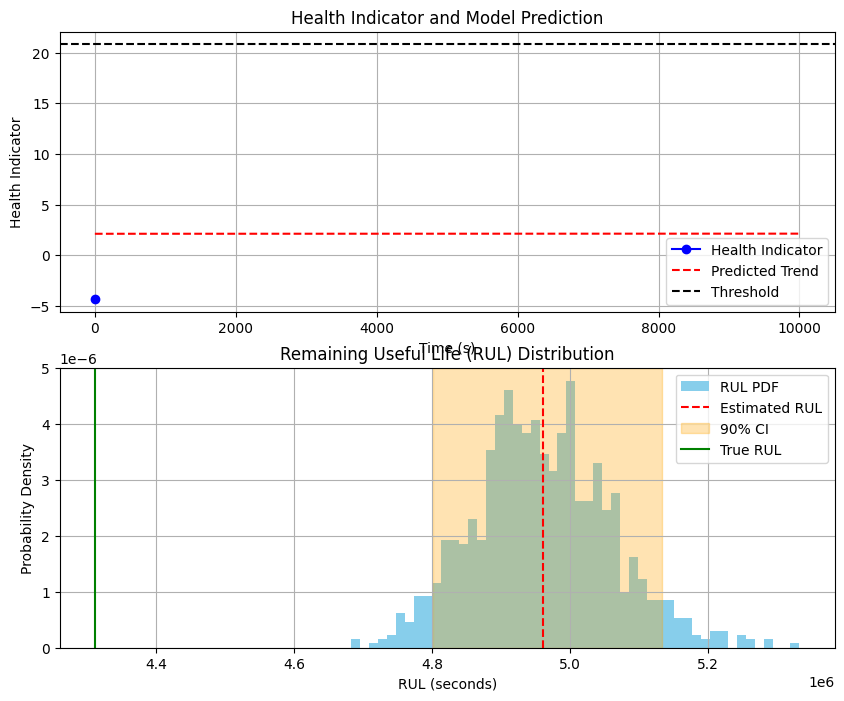

In [15]:
import matplotlib.pyplot as plt

est_ruls = []
true_ruls = []
ciruls = []
pdf_ruls = []

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8))

from matplotlib import cm

for i in range(len(health_data) - 1):
    t = time_numeric[i]
    h = health_data[i]

    mdl.update(t, h)

    est_rul, ci_rul, pdf_rul = mdl.predict_rul(t, h, threshold)
    true_rul = time_numeric[-1] - t

    est_ruls.append(est_rul)
    true_ruls.append(true_rul)
    ciruls.append(ci_rul)
    pdf_ruls.append(pdf_rul)

    # --- PLOT 1: health trend ---
    ax1.clear()
    ax1.plot(time_numeric[:i+1], health_data[:i+1], 'bo-', label="Health Indicator")
    t_vals = np.linspace(t, t + 10000, 100)
    pred_vals = mdl.phi + np.exp(mdl.mean[0]) * np.exp(mdl.mean[1] * t_vals)
    ax1.plot(t_vals, pred_vals, 'r--', label="Predicted Trend")
    ax1.axhline(y=threshold, color='k', linestyle='--', label="Threshold")
    ax1.set_title("Health Indicator and Model Prediction")
    ax1.set_xlabel("Time (s)")
    ax1.set_ylabel("Health Indicator")
    ax1.legend()
    ax1.grid(True)

    # --- PLOT 2: RUL distribution ---
    ax2.clear()
    if len(pdf_rul) > 0:
        ax2.hist(pdf_rul, bins=50, density=True, color='skyblue', label='RUL PDF')
        ax2.axvline(est_rul, color='r', linestyle='--', label='Estimated RUL')
        ax2.axvspan(ci_rul[0], ci_rul[1], color='orange', alpha=0.3, label='90% CI')
    ax2.axvline(true_rul, color='g', linestyle='-', label='True RUL')
    ax2.set_title("Remaining Useful Life (RUL) Distribution")
    ax2.set_xlabel("RUL (seconds)")
    ax2.set_ylabel("Probability Density")
    ax2.legend()
    ax2.grid(True)

    plt.pause(0.1)


